In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omarasabri456
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format


100%|██████████| 25.7M/25.7M [00:00<00:00, 114MB/s]


# ***Import Libraries***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# ***Exploratory Data Analysis (EDA)***

In [3]:
train_df = pd.read_csv('/content/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv')
valid_df = pd.read_csv('/content/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv')
test_df = pd.read_csv('/content/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')

In [4]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(40000, 2)
(5000, 2)
(5000, 2)


In [5]:
train_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
valid_df.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [7]:
test_df.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


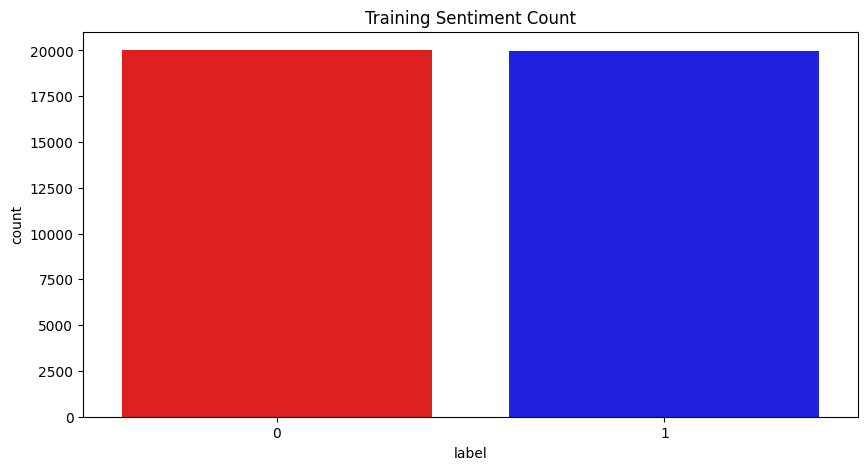

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',data=train_df,palette=['red','blue'])
plt.title('Training Sentiment Count')
plt.show()

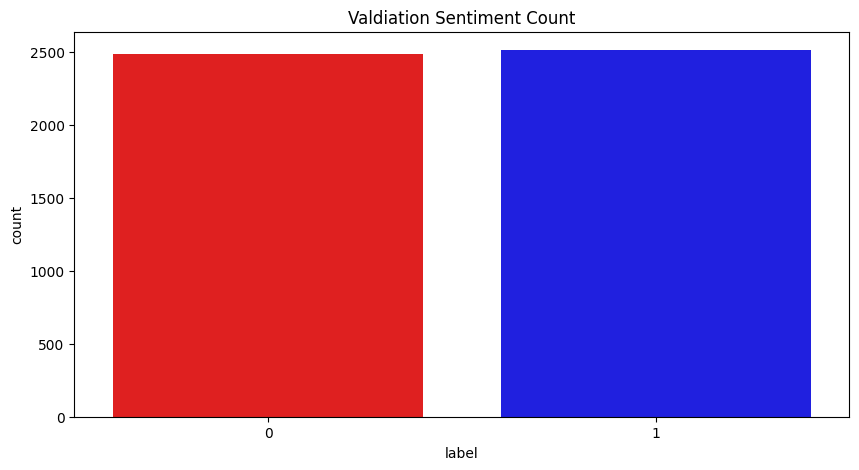

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',data=valid_df,palette=['red','blue'])
plt.title('Valdiation Sentiment Count')
plt.show()

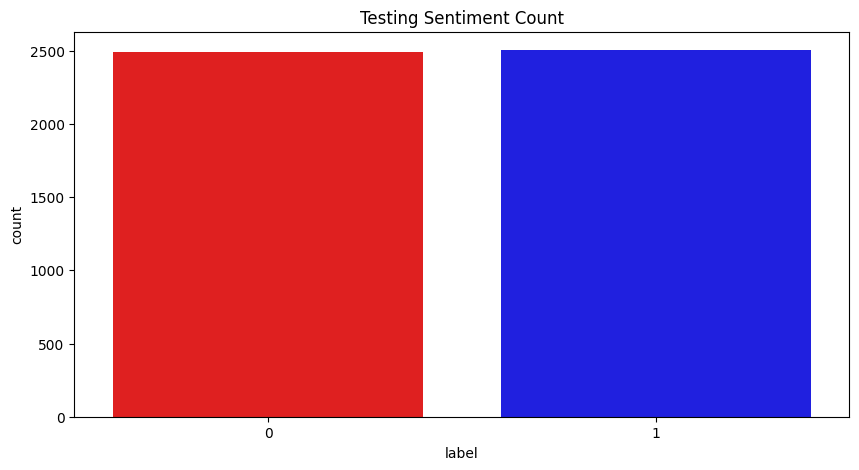

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',data=test_df,palette=['red','blue'])
plt.title('Testing Sentiment Count')
plt.show()

In [11]:
train_df['label'].unique(), valid_df['label'].unique(), test_df['label'].unique()

(array([0, 1]), array([0, 1]), array([0, 1]))

In [12]:
train_df.isnull().sum(), valid_df.isnull().sum(), test_df.isnull().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

# ***Text Preprocessing***

In [13]:
link_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df_with_links = train_df[train_df['text'].str.contains(link_pattern, na=False)]
df_with_links

,text,label
205,"I just saw this movie on HBO, and it was reall...",1
661,Inarguably one of the most interesting filmmak...,1
2704,There is only one word to define the whole mov...,0
3097,"The original 1965 Japanese film ""Gamera"" http:...",0
3199,"Airwolf The Movie, A variation on the original...",1
...,...,...
36568,In trying to keep up with the hipness of youth...,0
37203,This quasi J-horror film followed a young woma...,0
37453,Ridiculous. This movie is actually a vehicle f...,0
37961,I am so upset that ABC is giving up on yet ano...,1


In [14]:
train_df['text'][100]

'In the history of cinema, every great film-maker had to create a first film. Many times when viewed after they have become a success, a light bulb goes on in our heads. The connection is made and we see the solid foundation from where they started. So it is with HORSES ON MARS. It is the subtle humor woven around a seemingly straight-forward narrative that tells a great story, but allows you to enjoy the visuals at the same time. In the imagery, I found great attention to detail and a production polish that is rare in any student film.<br /><br />A young film-maker always has improvements to be made. But if Mr. Anderson continues on this path, I think we will someday look back on this film as the beginning a great career.<br /><br />You should definitely view this film. Nothing beats the grandeur of the big screen.'

In [15]:
STOPWORDS=set(stopwords.words('english'))

In [16]:
def remove_url_and_email(string):

    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')

    string = url_pattern.sub(r'', string)
    string = email_pattern.sub(r'', string)

    return string

def remove_html(text):

    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'',text)
def text_preprocessing(df):

  df['text_cleaned'] = df['text'].apply(lambda x: " ".join([word.lower() for word in x.split()])) # Lowercase
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: remove_url_and_email(x)) # Remove URLs
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: remove_html(x)) # Remove HTML tags
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: " ".join([word for word in x.split() if word not in STOPWORDS])) # Remove stopwords
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x)) # Remove punctuation
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'\d+', '', x)) # Remove digits
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x)) # Remove extra whitespace
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 2])) # Remove short words

  return df

In [17]:
train_df = text_preprocessing(train_df)
valid_df = text_preprocessing(valid_df)
test_df = text_preprocessing(test_df)

In [18]:
train_df.head()

,text,label,text_cleaned
0,I grew up (b. 1965) watching and loving the Th...,0,grew watching loving thunderbirds mates school...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chips expectatio...
2,Why do people who do not know what a particula...,0,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movies bor...
4,Im a die hard Dads Army fan and nothing will e...,1,die hard dads army fan nothing ever change tha...


In [19]:
valid_df.head()

,text,label,text_cleaned
0,It's been about 14 years since Sharon Stone aw...,0,years since sharon stone awarded viewers leg c...
1,someone needed to make a car payment... this i...,0,someone needed make car payment truly awful ma...
2,The Guidelines state that a comment must conta...,0,guidelines state comment must contain minimum ...
3,This movie is a muddled mish-mash of clichés f...,0,movie muddled mish mash clichés recent cinema ...
4,Before Stan Laurel became the smaller half of ...,0,stan laurel became smaller half all time great...


In [20]:
test_df.head()

,text,label,text_cleaned
0,I always wrote this series off as being a comp...,0,always wrote series complete stink fest jim be...
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0,watched dir steve purcell typical mary kate as...
2,This movie was so poorly written and directed ...,0,movie poorly written directed fell asleep minu...
3,The most interesting thing about Miryang (Secr...,1,interesting thing miryang secret sunshine acto...
4,"when i first read about ""berlin am meer"" i did...",0,first read berlin meer expect much thought rig...


In [21]:
train_df['length'] = train_df['text_cleaned'].apply(lambda x: len(x))
valid_df['length'] = valid_df['text_cleaned'].apply(lambda x: len(x))
test_df['length'] = test_df['text_cleaned'].apply(lambda x: len(x))

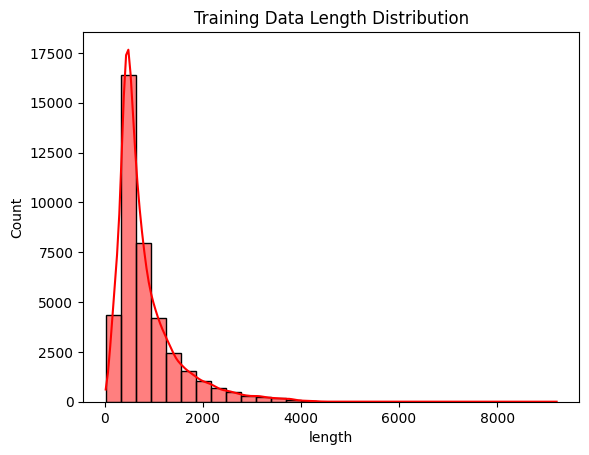

In [22]:
sns.histplot(train_df['length'],kde=True,color='red',bins=30)
plt.title('Training Data Length Distribution')
plt.show()

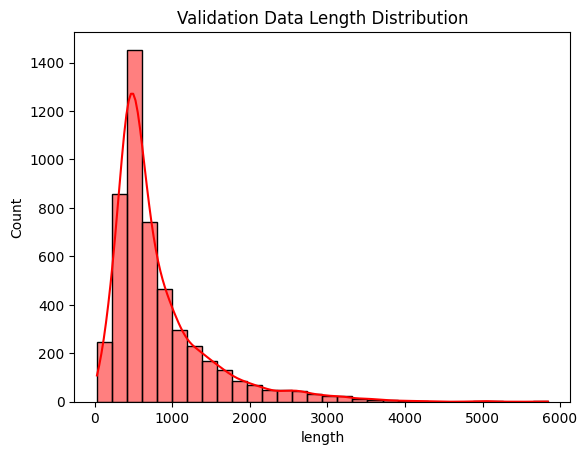

In [23]:
sns.histplot(valid_df['length'],kde=True,color='red',bins=30)
plt.title('Validation Data Length Distribution')
plt.show()

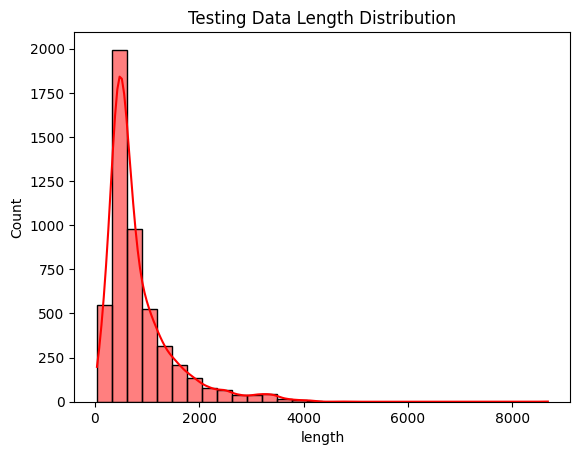

In [24]:
sns.histplot(test_df['length'],kde=True,color='red',bins=30)
plt.title('Testing Data Length Distribution')
plt.show()

In [25]:
train_text = train_df['text_cleaned'].tolist()
valid_text = valid_df['text_cleaned'].tolist()
test_text = test_df['text_cleaned'].tolist()

In [26]:
tokenize = Tokenizer(oov_token="<OOV>")
tokenize.fit_on_texts(train_text)
vocab_size = len(tokenize.word_index) + 1
vocab_size

92002

In [27]:
MAX_LENGTH = 120

In [28]:
X_train = tokenize.texts_to_sequences(train_text)
X_valid = tokenize.texts_to_sequences(valid_text)
X_test = tokenize.texts_to_sequences(test_text)
X_train = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
X_valid = pad_sequences(X_valid, maxlen=MAX_LENGTH, padding='post')
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [29]:
y_train = train_df['label'].values
y_valid = valid_df['label'].values
y_test = test_df['label'].values

# ***Build RNN Model***

In [30]:
EMBEDDING_DIM = 128

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [33]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=5,
                                                 min_lr=1e-7,
                                                 mode='min')

ealystopping=tf.keras.callbacks.EarlyStopping(patience=3,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

In [34]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),
                    batch_size=64,verbose=1,
                    callbacks=[ealystopping,reduce_lr])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.5351 - loss: 0.6824 - val_accuracy: 0.8238 - val_loss: 0.4285 - learning_rate: 1.0000e-04
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8665 - loss: 0.3680 - val_accuracy: 0.8636 - val_loss: 0.3309 - learning_rate: 1.0000e-04
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9264 - loss: 0.2333 - val_accuracy: 0.8680 - val_loss: 0.3495 - learning_rate: 1.0000e-04
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9577 - loss: 0.1538 - val_accuracy: 0.8706 - val_loss: 0.3134 - learning_rate: 1.0000e-04
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9630 - loss: 0.1337 - val_accuracy: 0.8762 - val_loss: 0.3291 - learning_rate: 1.0000e-04
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9766 - loss: 0.0976 - val_accuracy: 0.8678 - val_loss: 0.4467 - learning_rate: 1.0000e-04
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step -

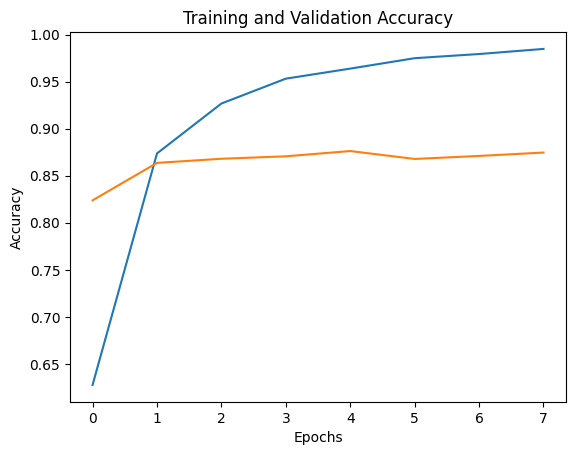

In [35]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

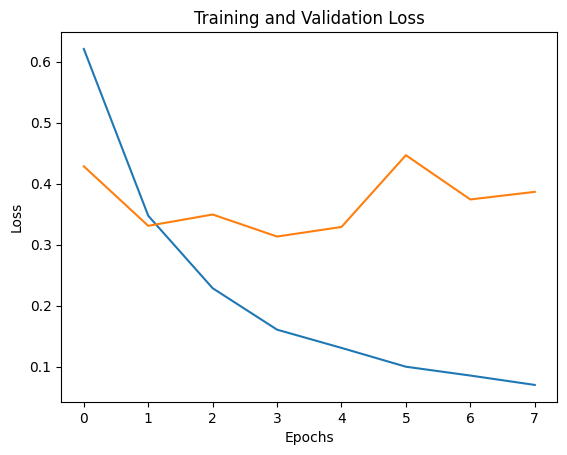

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [37]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8746 - loss: 0.3258
Test Loss: 0.3234659731388092
Test Accuracy: 0.8776000142097473


In [38]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


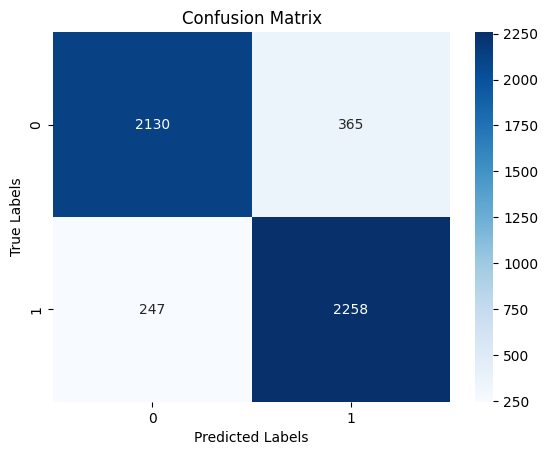

In [39]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [40]:
class_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87      2495
    Positive       0.86      0.90      0.88      2505

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



# ***Deployment***

In [46]:
text = "Absolutely amazing service"
review = text_preprocessing(pd.DataFrame({'text': [text]}))
review = review['text_cleaned'].tolist()
review = tokenize.texts_to_sequences(review)
review = pad_sequences(review, maxlen=MAX_LENGTH, padding='post')
prediction = model.predict(review)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [47]:
if prediction > 0.5:
    print('Positive')
else:
    print('Negative')

Positive
